### Automating COGS Calculation <br/><br/>

> The data in this notebook was provided as part of an assessment for a data analyst role I applied for in 2022. <br/><br/>
> I was given a CSV file containing shipment information and tasked with generating and presenting insights based on it. <br/><br/>

#### About the data: 

> In the code below, the 'date today' is set to July 5, 2022. <br/><br/>
> The start-of-month and end-of-month inventory values were randomly generated and both represent inventory for June 2022. <br/><br/>

#### Objectives:

> The goal is to automate the following tasks: a) Determine when shipments are expected to arrive, <br/><br/>
> b) Identify the specific shipments from which the remaining inventory originates (note: the inventory data is dummy data in this case), and <br/><br/>
> c) perform the calculation of COGS for the previous month. <br/><br/>


In [2]:
#import usual libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [4]:
#import the dataset
products_df = pd.read_csv("../../Projects_data/6.practice_files/Practice_file_1.csv", parse_dates=True)

#remove unnecessary columns from the dataframe 
products_df = products_df.drop([products_df.columns[10], products_df.columns[12], products_df.columns[16], products_df.columns[17]], axis=1)
products_df.head()

,Product Name,Order number,Market Place,Quantity,Shipping Cost/Unit,Production Cost/Unit,Total Cost/Unit (COGS),Total Order Cost,Production Lead Time (Days),Production Should be Ready in,Estimated Departure Date,Actual Lead Time,Shipping Lead Time,Shipping Route
0,ProductABC123,1st,Canada,300,$0.28,$2.34,$2.62,$787.30,33,6/1/2020,15-Jan-2020,89.0,56,Sea
1,ProductDEF173,1st,Canada,300,$0.60,$3.91,$4.51,"$1,353.55",33,6/1/2020,15-Jan-2020,89.0,56,Sea
2,ProductGEF223,1st,Canada,300,$0.76,$3.40,$4.16,"$1,246.59",33,6/1/2020,15-Jan-2020,89.0,56,Sea
3,ProductHIJ273,1st,Canada,300,$0.60,$3.98,$4.58,"$1,374.55",33,6/1/2020,15-Jan-2020,90.0,57,Sea
4,ProductKLM323,1st,Canada,440,$1.23,$3.70,$4.93,"$2,168.00",32,20/3/2020,29-Nov-2020,107.0,75,Sea


### Part 1: Data Cleanup

##### Change the data type of certain columns

In [51]:
def change_currency_col_dtype(df, columns_list, currency):
    for col in columns_list: 
        df[col] = df[col].str.split(currency).str[1] #this will remove the dollar signs 
        df[col] = pd.to_numeric(df[col].str.replace(",","")) #this will remove the commas 

def change_to_datetime_dtype(df, col, date_format):
    df[col] = pd.to_datetime(df[col], format=date_format)

def change_dtype(df, columns_list, fill_value=0, dtype_value=int):
    df[columns_list] =  df[columns_list].fillna(fill_value).astype(dtype_value)

#change the data type of columns containing currencies
columns_list_a = ["Shipping Cost/Unit", "Production Cost/Unit", "Total Cost/Unit (COGS)", "Total Order Cost"]
change_currency_col_dtype(products_df, columns_list_a, "$")

#change the data type of columns containing dates
change_to_datetime_dtype(products_df, "Production Should be Ready in", '%d/%m/%Y')
change_to_datetime_dtype(products_df, "Estimated Departure Date", '%d-%b-%Y')

#change the data type to int 
columns_list_b = ["Quantity", "Production Lead Time (Days)","Actual Lead Time", "Shipping Lead Time"]
change_dtype(products_df, columns_list_b)

#change the data type to categorical 
columns_list_c = ["Product Name", "Order number", "Market Place", "Shipping Route"]
change_dtype(products_df, columns_list_c, fill_value="None", dtype_value="category")

##### Check for missing values

In [52]:
def check_missing_values(df):
    missing_values = pd.DataFrame({"Total missing values": df.isna().sum(),
                                   "% of missing values": df.isna().sum()/df.count()})
    return missing_values

check_missing_values(products_df)

,Total missing values,% of missing values
Product Name,0,0.000000
Order number,0,0.000000
Market Place,0,0.000000
Quantity,0,0.000000
Shipping Cost/Unit,11,0.130952
Production Cost/Unit,0,0.000000
Total Cost/Unit (COGS),0,0.000000
Total Order Cost,0,0.000000
Production Lead Time (Days),0,0.000000
Production Should be Ready in,0,0.000000


> The missing values in the "Estimated Departure Date" column is in "NaT" format. We'll leave it as is. 

In [53]:
#fill in missing values in the "Shipping cost" column with 0
products_df["Shipping Cost/Unit"] = products_df["Shipping Cost/Unit"].fillna(0)

In [54]:
#replace the negative values in the "Shipping Lead Time" column with the mean value
products_df["Shipping Lead Time"] = np.where(products_df["Shipping Lead Time"] <=0, 75, products_df["Shipping Lead Time"])

##### Add a new column

In [55]:
#add a new column to indicate the estimated arrival date of the products 
def estimate_arrival_date_of_goods(df, departure_date_col, ship_lead_time_col, new_col_name, unit_val="days"):
    df[new_col_name] = df[departure_date_col] + pd.to_timedelta(df[ship_lead_time_col], unit=unit_val)

estimate_arrival_date_of_goods(products_df, "Estimated Departure Date", "Shipping Lead Time", "Estimated Arrival Date") 
products_df.head()

,Product Name,Order number,Market Place,Quantity,Shipping Cost/Unit,Production Cost/Unit,Total Cost/Unit (COGS),Total Order Cost,Production Lead Time (Days),Production Should be Ready in,Estimated Departure Date,Actual Lead Time,Shipping Lead Time,Shipping Route,Estimated Arrival Date
0,ProductABC123,1st,Canada,300,0.28,2.34,2.62,787.30,33,2020-01-06,2020-01-15,89,56,Sea,2020-03-11
1,ProductDEF173,1st,Canada,300,0.60,3.91,4.51,1353.55,33,2020-01-06,2020-01-15,89,56,Sea,2020-03-11
2,ProductGEF223,1st,Canada,300,0.76,3.40,4.16,1246.59,33,2020-01-06,2020-01-15,89,56,Sea,2020-03-11
3,ProductHIJ273,1st,Canada,300,0.60,3.98,4.58,1374.55,33,2020-01-06,2020-01-15,90,57,Sea,2020-03-12
4,ProductKLM323,1st,Canada,440,1.23,3.70,4.93,2168.00,32,2020-03-20,2020-11-29,107,75,Sea,2021-02-12


### Part 2: Data Exploration

##### How many unique products are there currently?

In [56]:
#how many unique products are there currently?
products_df["Product Name"].value_counts()

Product Name
ProductDEF173     17
ProductHIJ273     16
ProductABC123     15
ProductKLM323     14
ProductNMO373     14
ProductGEF223     12
ProductWXY523      2
ProductZAA573      2
ProductPQR423      1
ProductSTUV473     1
ProductZAB623      1
Name: count, dtype: int64

> There are 11 unique products in the dataset.

##### How many products are not yet received as of today? Date today is '2022-07-05'.

In [57]:
#track the shipments that are not yet received
def check_products_to_receive(df, arrival_date_col, grp_by_col, quantity_col, filter_date):
    pending_products_df = df[df[arrival_date_col] > filter_date]
    pending_products_grp = pending_products_df.groupby(grp_by_col, observed=False).agg({quantity_col:"sum"})
    
    return  pending_products_grp[pending_products_grp[quantity_col]>0]

columns_list_d = ["Product Name", "Order number" ,"Shipping Route", "Estimated Departure Date"]
check_products_to_receive(products_df, "Estimated Arrival Date", columns_list_d, "Quantity", "2022-07-05")

Quantity
Product Name  Order number Shipping Route Estimated Departure Date          
ProductABC123 12th         Sea            2022-01-20                    1050
ProductDEF173 16th         Fast sea       2022-05-13                     900
              17th         Sea            2022-10-06                     500
ProductGEF223 12th         Sea            2022-03-21                     600
ProductKLM323 11th         Sea            2021-11-05                     300
              14th         Fast sea       2022-10-06                     600
ProductNMO373 12th         Fast sea       2022-07-07                     100
ProductWXY523 2nd          Fast sea       2022-07-07                     100

> The above orders are still not received in the warehouse. 

##### How many shipments were received previously for each product

In [58]:
#check the shipments received previously for each product
def check_prev_shipments_for_product(df, arrival_date_col, product_name_col, product, from_filter_date, to_filter_date):
    #filter the recent shipments of the item
    filter1 = df[arrival_date_col] >= from_filter_date
    filter2 = df[arrival_date_col] < to_filter_date
    filter3 = df[product_name_col] == product
    filtered_df = df[filter1&filter2&filter3].sort_values(arrival_date_col, ascending=False) #sort by most recent shipment

    return  filtered_df

check_prev_shipments_for_product(products_df, "Estimated Arrival Date", "Product Name", "ProductABC123", from_filter_date=min(products_df["Estimated Arrival Date"]), to_filter_date="2022-07-05") #date is set to July 05, 2022

,Product Name,Order number,Market Place,Quantity,Shipping Cost/Unit,Production Cost/Unit,Total Cost/Unit (COGS),Total Order Cost,Production Lead Time (Days),Production Should be Ready in,Estimated Departure Date,Actual Lead Time,Shipping Lead Time,Shipping Route,Estimated Arrival Date
57,ProductABC123,11th,Canada,140,0.90,2.38,3.28,459.10,70,2021-03-19,2021-07-21,264,194,Fast sea,2022-01-31
65,ProductABC123,13th,Canada,490,0.72,2.39,3.11,1524.78,35,2021-09-08,2021-09-30,141,106,Fast sea,2022-01-14
41,ProductABC123,9th,Canada,200,0.36,2.35,2.71,541.77,38,2021-01-10,2021-03-13,206,168,Fast sea,2021-08-28
42,ProductABC123,10th,Canada,200,0.36,2.35,2.71,541.77,38,2021-01-10,2021-03-13,206,168,Fast sea,2021-08-28
38,ProductABC123,6th,Canada,200,0.85,2.35,3.20,640.93,38,2021-01-10,2021-03-13,146,108,Fast sea,2021-06-29
39,ProductABC123,7th,Canada,200,0.85,2.35,3.20,640.93,38,2021-01-10,2021-03-13,146,108,Fast sea,2021-06-29
40,ProductABC123,8th,Canada,200,0.85,2.35,3.20,640.93,38,2021-01-10,2021-03-13,146,108,Fast sea,2021-06-29
22,ProductABC123,4th,Canada,100,0.97,2.33,3.30,330.37,30,2020-11-07,2020-11-29,118,88,Fast sea,2021-02-25
23,ProductABC123,5th,Canada,400,0.97,2.33,3.30,1321.47,30,2020-11-07,2020-11-29,118,88,Fast sea,2021-02-25
12,ProductABC123,3rd,Canada,1000,0.45,2.34,2.79,2787.50,26,2020-07-18,2020-07-22,65,39,Fast sea,2020-08-30


### Part 3: Calculating the COGS

##### Generate random numbers to represent the available stock for each product

In [59]:
#generate random numbers to represent the available stock for each product 
np.random.seed(42)
stock_prev_month = pd.DataFrame({"Product Name": products_df["Product Name"].unique(),
                                 "Stock - SOM": np.random.randint(0, 500, size=11), #SOM stands for "start of month"
                                 "Units Sold": np.random.randint(0, 20, size=11)})
stock_prev_month["Stock - EOM"] = stock_prev_month["Stock - SOM"] - stock_prev_month["Units Sold"] #EOM stands for "end of month"
stock_prev_month

,Product Name,Stock - SOM,Units Sold,Stock - EOM
0,ProductABC123,102,10,92
1,ProductDEF173,435,10,425
2,ProductGEF223,348,3,345
3,ProductHIJ273,270,7,263
4,ProductKLM323,106,2,104
5,ProductNMO373,71,1,70
6,ProductPQR423,188,11,177
7,ProductSTUV473,20,5,15
8,ProductWXY523,102,1,101
9,ProductZAA573,121,0,121


#### How to Calculate the COGS? <br/><br/>

> Below is the formula to get the COGS for the previous month, June 2022. <br/><br/>

> We need to determine the cost of inventory at the start [ June 01,  2022 ] and end of the month [ June 30, 2022 ]. <br/><br/>

> It is necessary to identify the specific shipments from which the remaining units originated, in order to accurately calculate the COGS. <br/><br/>

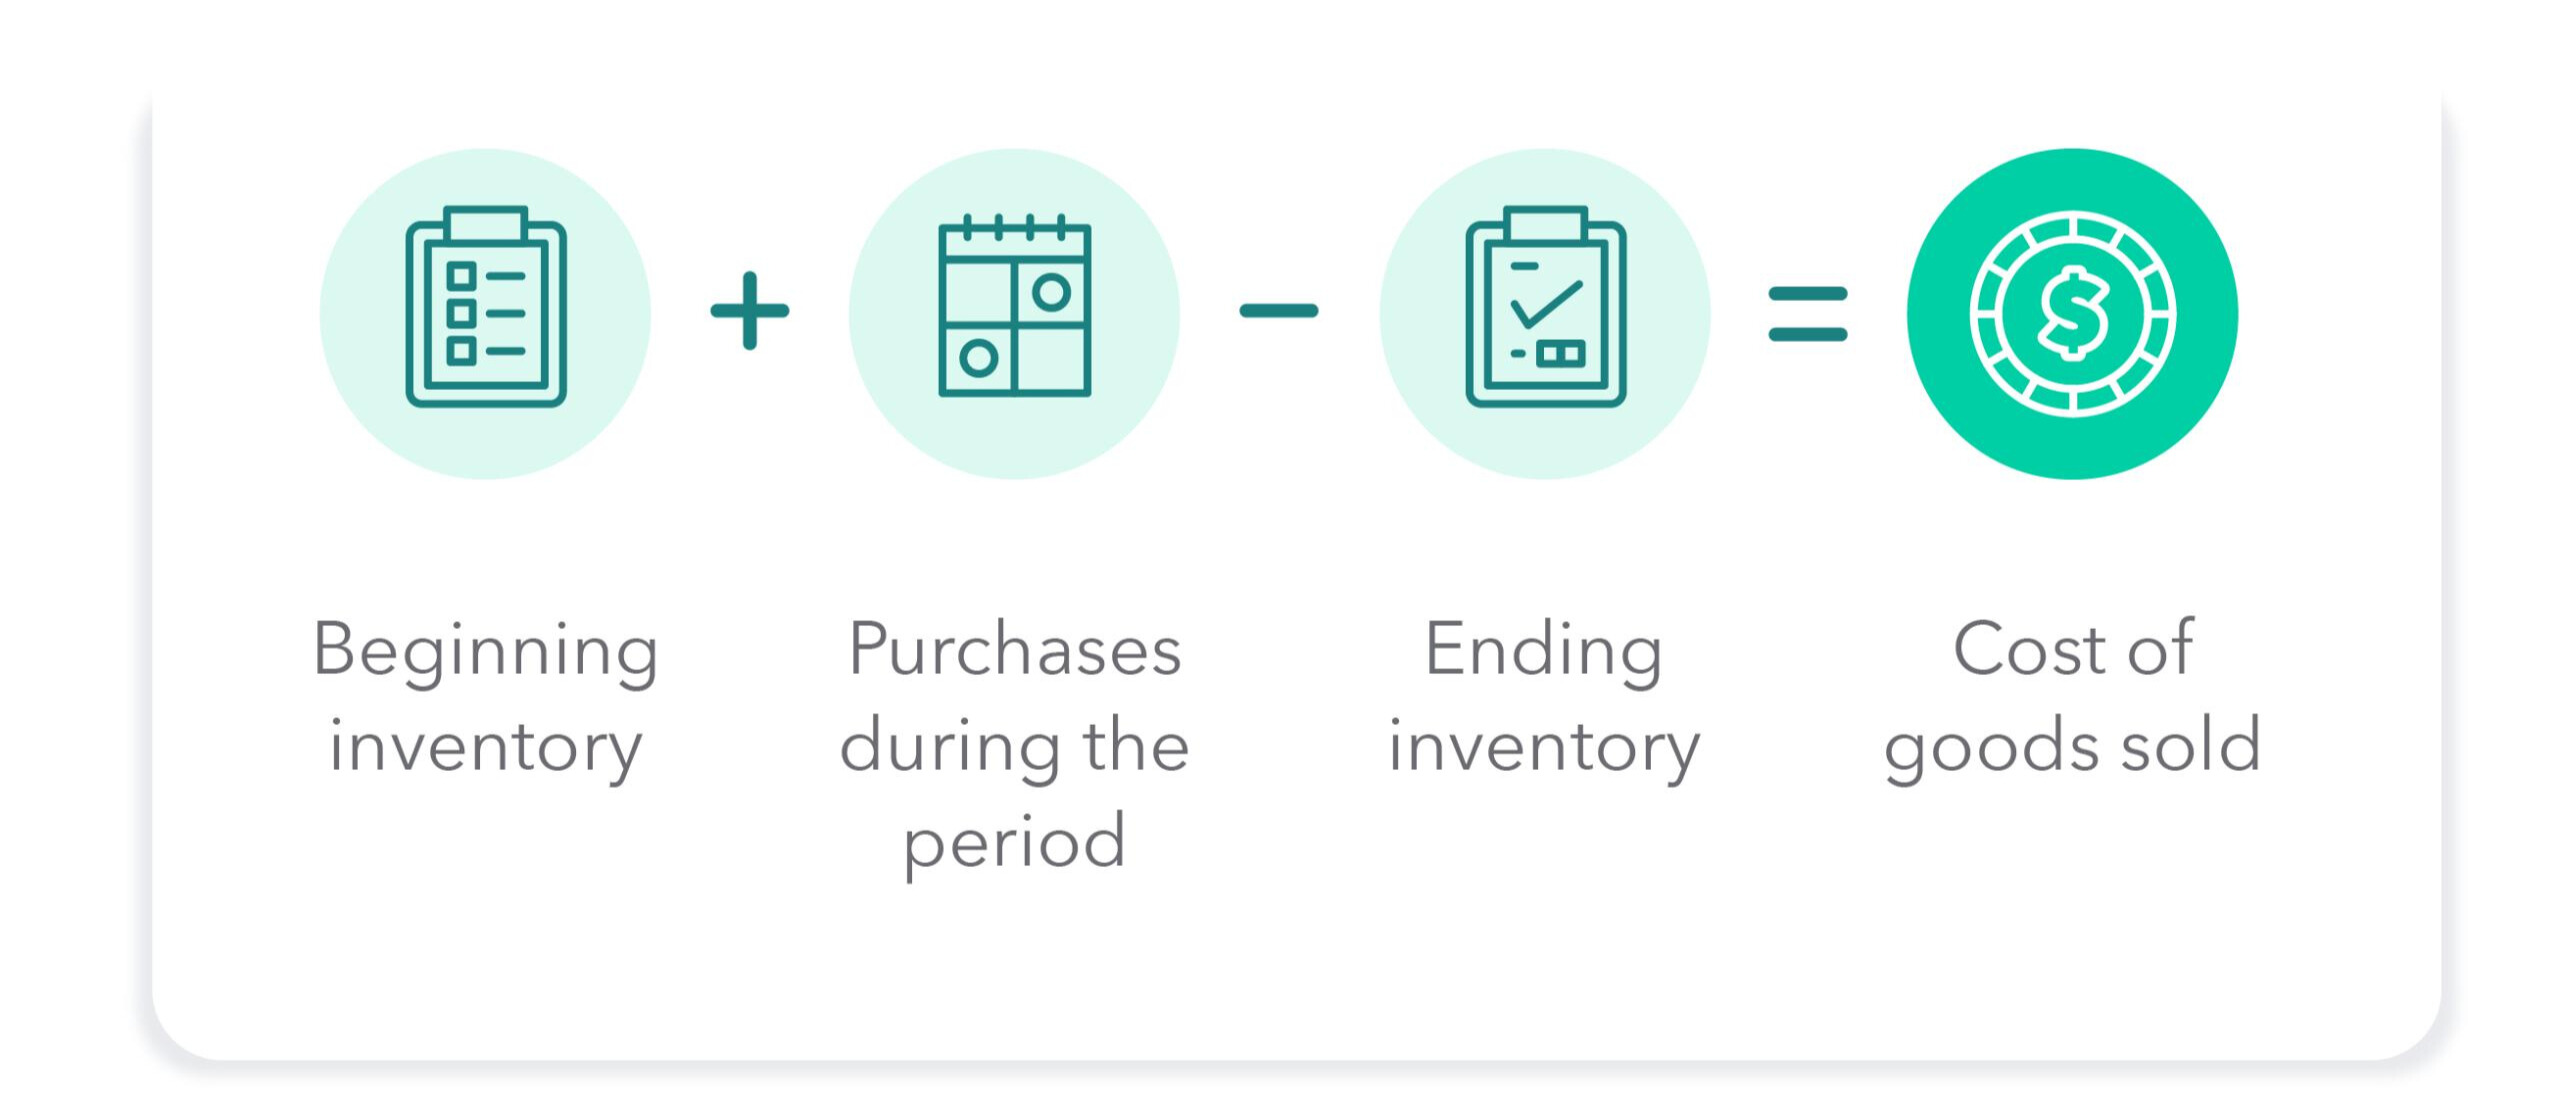

In [60]:
Image(filename="/home/apol/Downloads/All Pandas/Projects_notebook/5.practice_files/COGS_.png")

In [68]:
#calculate the cost of remaining inventory for a given period
def check_cost_of_remaining_inventory(eta_date, available_stock_col): #select either the SOM stock or EOM stock in "available_stock_col" parameter
    products_stock_list = []
    products_cost_per_unit_list = []
    products_order_number_list = []

    for prod in stock_prev_month["Product Name"]:
        #check the available stock of the item in the "stock_prev_month" dataframe
        available_stock = stock_prev_month[stock_prev_month["Product Name"]==prod][available_stock_col]
        if not available_stock.empty:
            available_stock = available_stock.iloc[0]  # Safely access the first element
        else:
            available_stock = 0

        #filter the recent shipments of the item
        filter1 = products_df["Estimated Arrival Date"] < eta_date
        filter2 = products_df["Product Name"] == prod
        filtered_df = products_df[filter1&filter2].sort_values("Estimated Arrival Date", ascending=False).reset_index(drop=True) #sort by most recent shipment

        stock_list = [] #list of unit breakdown

        #check how many units are from which shipment
        for shipment_q in filtered_df["Quantity"]: #total quantity per batch of shipment
            units = available_stock - shipment_q
            if units >= 0:
                stock_list.append(shipment_q)
                products_stock_list.append((prod, shipment_q))
                available_stock = units
            else:
                corrected_units = shipment_q + units
                stock_list.append(corrected_units)
                products_stock_list.append((prod, corrected_units))
                break
        #products_stock_list[prod] = stock_list

        #check the total cost per unit for each shipment 
        for stock_q in range(len(stock_list)):
            cost = filtered_df["Total Cost/Unit (COGS)"][stock_q] #cost per unit for each shipment
            products_cost_per_unit_list.append((prod, cost))

            order_number = filtered_df["Order number"][stock_q] #shipment name
            products_order_number_list.append((prod, order_number))

    #create a dataframe to consolidate the list above 
    df = pd.DataFrame({"Product Name": [key for key, val in products_stock_list],
                       "Order Number": [val for key, val in products_order_number_list],
                       "Stock": [val for key, val in products_stock_list],
                       "Cost Per Unit": [val for key, val in products_cost_per_unit_list]})
    df["Total Cost"] = df["Stock"] * df["Cost Per Unit"]

    #create a summary of the total cogs per product
    df_summary = df.groupby(["Product Name"]).agg({"Total Cost": "sum"})

    return df, df_summary

##### Cost of the Beginning Inventory

In [62]:
#get the total cost of the beginning inventory
beginning_inventory_df, beginning_inventory_summary = check_cost_of_remaining_inventory(eta_date="2022-06-01", available_stock_col="Stock - SOM")
beginning_inventory_summary

,Total Cost
Product Name,
ProductABC123,334.56
ProductDEF173,1959.30
ProductGEF223,1778.28
ProductHIJ273,1196.10
ProductKLM323,411.28
ProductNMO373,295.36
ProductPQR423,787.72
ProductSTUV473,88.40
ProductWXY523,403.92


##### Cost of the Ending Inventory

In [63]:
#get the total cost of the ending inventory
ending_inventory_df, ending_inventory_summary = check_cost_of_remaining_inventory(eta_date="2022-06-01", available_stock_col="Stock - EOM")
ending_inventory_summary

,Total Cost
Product Name,
ProductABC123,301.76
ProductDEF173,1917.50
ProductGEF223,1762.95
ProductHIJ273,1165.09
ProductKLM323,403.52
ProductNMO373,291.20
ProductPQR423,741.63
ProductSTUV473,66.30
ProductWXY523,399.96


In [64]:
#verify if any units arrived between June 1 and June 30, 2022.
check_prev_shipments_for_product(products_df, "Estimated Arrival Date", "Product Name", "ProductABC123", from_filter_date="2022-06-01", to_filter_date="2022-06-30") 

,Product Name,Order number,Market Place,Quantity,Shipping Cost/Unit,Production Cost/Unit,Total Cost/Unit (COGS),Total Order Cost,Production Lead Time (Days),Production Should be Ready in,Estimated Departure Date,Actual Lead Time,Shipping Lead Time,Shipping Route,Estimated Arrival Date


> Since no new shipments arrived during the month of June for ProductABC123, there's no "Purchased Inventory" to be included in the COGS calculation below. 

##### Total COGS 

In [100]:
#calculate the total COGS for ProductABC123 for the month of June
total_cogs = beginning_inventory_summary.loc["ProductABC123", 'Total Cost'] - ending_inventory_summary.loc["ProductABC123", 'Total Cost']
units_sold_productABC123 = stock_prev_month[stock_prev_month["Product Name"] == "ProductABC123"]["Units Sold"][0]

print(f"The total COGS for ProductABC123 for June 2022 is {total_cogs:.2f}")
print(f"The COGS per unit for ProductABC123 is {total_cogs/units_sold_productABC123:.2f}")

The total COGS for ProductABC123 for June 2022 is 32.80
The COGS per unit for ProductABC123 is 3.28


##### Next steps <br/><br/>

> We can subtract the total COGS from the sales revenue of ProductABC123 to determine gross profit and calculate profit margins for June 2022. <br/><br/>

> We can adjust ProductABC123's current pricing based on the previous months' COGS. <br/><br/>

> COGS can also be used to evaluate inventory turnover and manage stock levels. <br/><br/>
